In [1]:
import math
import sys
sys.path.append('../darknight/')
from utils import array_in_nd_array, remove_space, r2pcorr,struc2mol
import numpy as np
import pandas as pd
import darkchem
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.linear_model import LinearRegression
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools,Draw
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
model = darkchem.utils.load_model('../Final Trained DarkChem Network Weights/N7b_[M+H]')

In [3]:
# imput reactants and products
smiles = {'Reactants': ['CC(=O)C', 'CCC(=O)C', 'CCCC(=O)C', 'CCC(=O)CC', 'CC(=O)CC(=O)C','CCCC(=O)C(=O)C',
                        'CCCC(=O)CC', 'O=C1CCCCC1', 'O=C1CCCC1C', 'COCC(=O)C', 'CC(=O)c1ccccc1','CC(=O)CCC(=O)C'], 
        'Products': ['CC(O)C', 'CCC(O)C', 'CCCC(O)C', 'CCC(CC)O', 'CC(CC(O)C)O',
                    'CCCC(C(O)C)O','CCCC(CC)O', 'OC1CCCCC1', 'OC1CCCC1C', 'COCC(O)C', 'CC(c1ccccc1)O','CC(CCC(O)C)O']}

# removed the original fifth and sixth reactions due to the products don't belong to the combined smiles strings file

In [4]:
#transform to DataFrame type
smiles = pd.DataFrame(smiles)
smiles

,Reactants,Products
0,CC(=O)C,CC(O)C
1,CCC(=O)C,CCC(O)C
2,CCCC(=O)C,CCCC(O)C
3,CCC(=O)CC,CCC(CC)O
4,CC(=O)CC(=O)C,CC(CC(O)C)O
5,CCCC(=O)C(=O)C,CCCC(C(O)C)O
6,CCCC(=O)CC,CCCC(CC)O
7,O=C1CCCCC1,OC1CCCCC1
8,O=C1CCCC1C,OC1CCCC1C
9,COCC(=O)C,COCC(O)C


In [5]:
rdata_df = {'smiles': smiles['Reactants']}
rdata_df = pd.DataFrame(data = rdata_df)
pdata_df = {'smiles': smiles['Products']}
pdata_df = pd.DataFrame(data = pdata_df)

In [6]:
#transform smiles strings to molecule structures
r_structure_df = struc2mol(rdata_df)
p_structure_df = struc2mol(pdata_df)

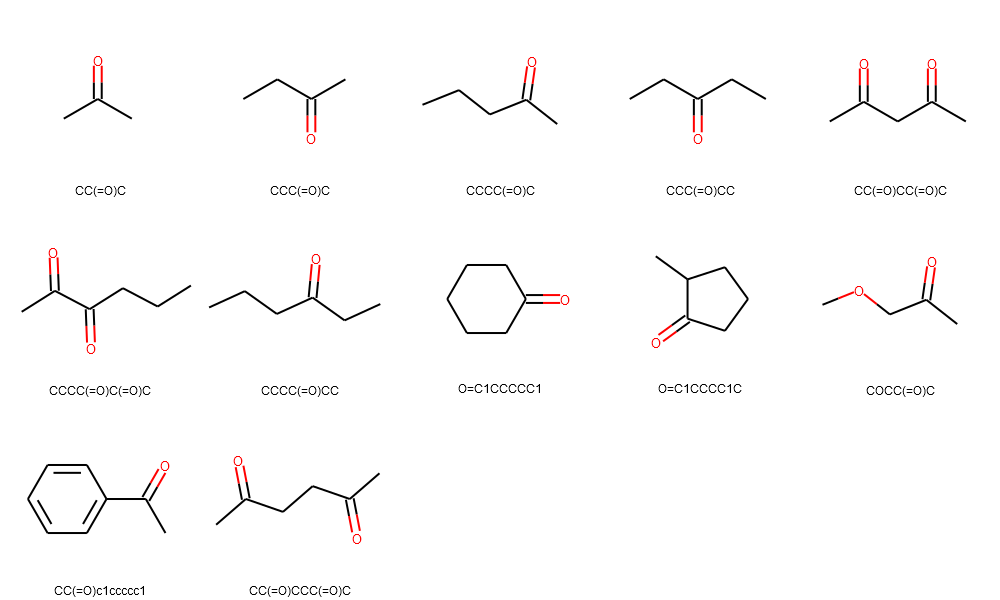

In [7]:
# display the products smiles strings with their molecule structures
display(PandasTools.FrameToGridImage(r_structure_df,column='mol', legendsCol='smiles',molsPerRow=5))

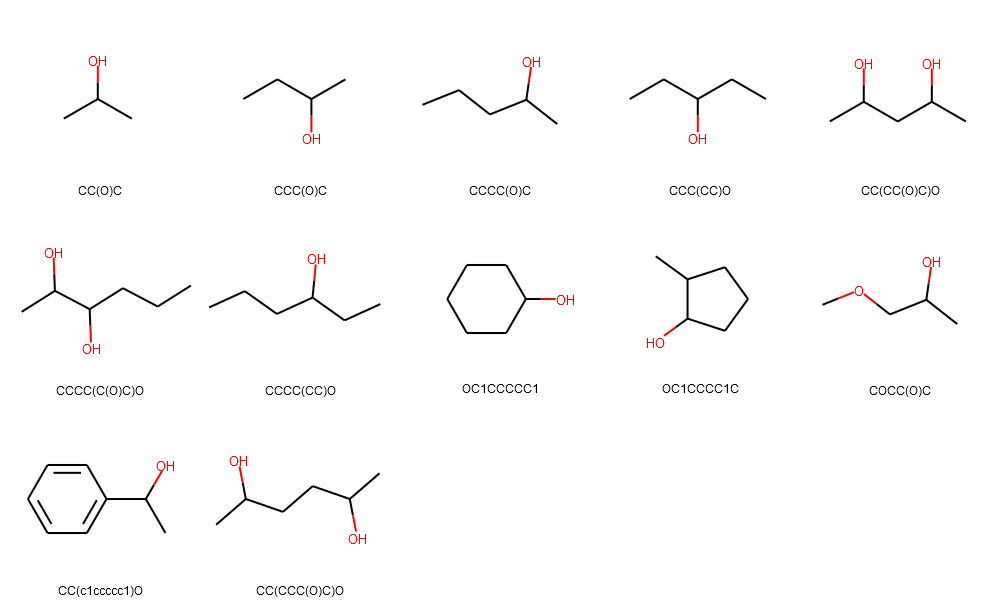

In [8]:
display(PandasTools.FrameToGridImage(p_structure_df,column='mol', legendsCol='smiles',molsPerRow=5))

In [9]:
#transform smiles string to vectors
rvec = [darkchem.utils.struct2vec(reactant).astype(int) for reactant in smiles['Reactants']]
pvec = [darkchem.utils.struct2vec(product).astype(int) for product in smiles['Products']]
#tranform list to nd.array
rvec = np.array(rvec)
pvec = np.array(pvec)
#transform numpy array to list  
#rvec = rvec.tolist() 
#pvec = pvec.tolist()
#smiles['rxnvector'] = [smilesdf.pvec[i] - smilesdf.rvec[i] for i in range(len(smilesdf))]

In [10]:
#generate the latent space representation for reactants and products
r_latent = model.encoder.predict(rvec)
p_latent = model.encoder.predict(pvec)

In [11]:
# transform the path,pvec and rvec(latent vectors) lists to dataframe
#pathdf = pd.DataFrame(path)
rvecdf = pd.DataFrame(r_latent)
pvecdf = pd.DataFrame(p_latent)

In [12]:
# calculate the correlation between the latent reactant vectors to product vectors
r2p = r2pcorr(rvecdf,pvecdf)
r2p

,Correlation
0,0.989565
1,0.985863
2,0.986768
3,0.991189
4,0.967385
5,0.94999
6,0.990679
7,0.972999
8,0.966398
9,0.987851


In [13]:
r2p.mean()

Correlation    0.972763
dtype: float64

In [14]:
#load regression analysis set
x = rvecdf.iloc[:,0:128].values
y = pvecdf.iloc[:,0:128].values

In [15]:
# split the training set and testing set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=1234)

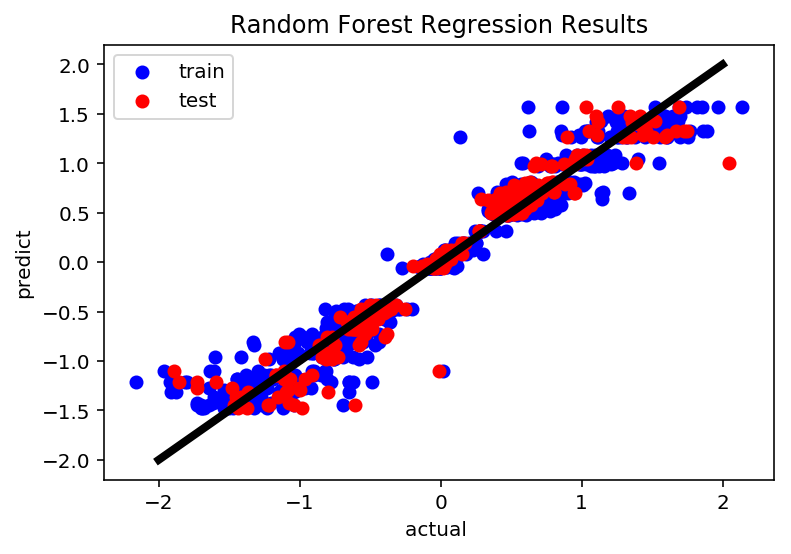

In [16]:
# Fitting the Regression model to the dataset

from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state = 123, min_samples_split=15)
regressor.fit(X_train,y_train)

# Predicting a new result with the Random Forest Regression

Ytrain_Pred = regressor.predict(X_train)
Ytest_Pred = regressor.predict(X_test)

# Visualising the Random Forest Regression results in higher resolution and smoother curve
#X_Grid = np.arange(min(X), max(X), 0.01)
#X_Grid = X_Grid.reshape((len(X_Grid), 1))
plt.scatter(y_train,Ytrain_Pred, color = 'blue',label = 'train')
plt.scatter(y_test,Ytest_Pred, color = 'red',label = 'test')
#plt.plot(X_Grid, regressor.predict(X_Grid), color = 'black')
plt.plot([-2,2],[-2,2],lw=4,color='black')
plt.title('Random Forest Regression Results')
plt.xlabel('actual ')
plt.ylabel('predict')
plt.legend(loc = 'best')
plt.show()

In [17]:
# predict the prodcut of Aceton
smi = 'CCCCCC/C=C/C=O'

In [18]:
#transform smiles string to structure vector
test = darkchem.utils.struct2vec(smi)

In [19]:
# shape the test list
test = np.array(test)
test = test.reshape(-1,100)

In [20]:
# generate the latent space vectors of Aceton
t_l = model.encoder.predict(test)

In [21]:
# predict the latent sapce vector of Aceton product using Aceton latent vector
t_pre = regressor.predict(t_l.reshape(1,-1))

In [22]:
#transform product latent space vector to structure vector
t_pred = model.decoder.predict(t_pre)

In [23]:
#search and match the specific prodcuts with the predicted structure vector
trs = darkchem.utils.beamsearch(t_pred, k=10)
# because k = 10, so there will be 10 results, you can change the value of k to get the amount of predicted products.

In [24]:
# shaping
trs = trs.flatten()
trs = trs.reshape(-1,100)

In [25]:
# transform structure vectors to smiles strings
v2s = [darkchem.utils.vec2struct(trs[i]) for i in range(len(trs))]

In [26]:
# transform Dict to DataFrame
sms = {'smiles': v2s}
sms = pd.DataFrame(data = sms)
sms

,smiles
0,CCCC(NCC
1,CCCC(CC
2,CCCCCCCC
3,CCCC=C)C
4,CCCC=NCC
5,CCCC=CC
6,CCCC(CC
7,CCCC=CC
8,CCCC(CCC
9,CCCC=CCC


In [27]:
#transform smiles strings to molecule structures
df = struc2mol(sms)

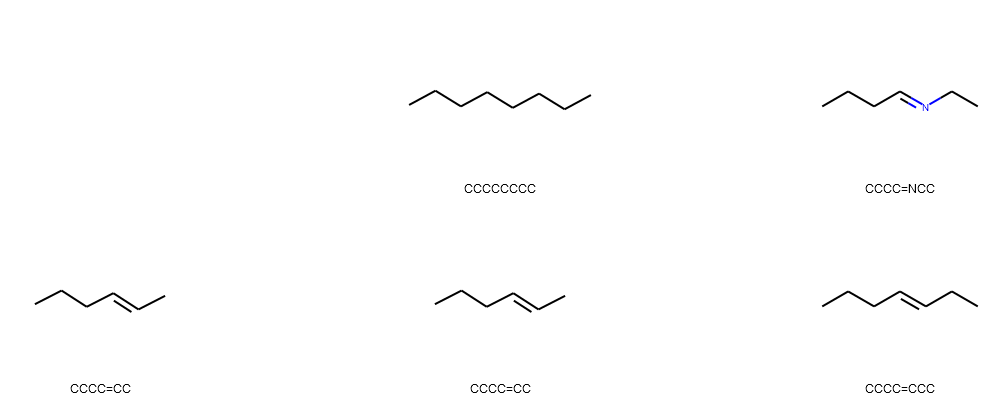

In [28]:
# display the products smiles strings with their molecule structures
display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=5))
# contain invalid molecules from the prediction result

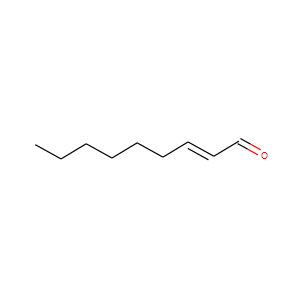

In [29]:
# the actual molecule structure of reactant
mol = Chem.MolFromSmiles('CCCCCC/C=C/C=O')
Draw.MolToImage(mol)

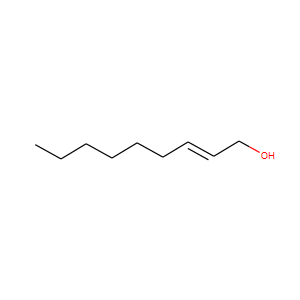

In [30]:
# the actual molecule structure of product
mol = Chem.MolFromSmiles('CCCCCC/C=C/CO')
Draw.MolToImage(mol)